In [29]:
import pandas as pd
import numpy as np

fsp_path = 'fsp_above_2019.csv'
satcat_path = 'satcat_above_2019.csv'
fsp_starlink_path = 'fsp_above_2019_starlink.csv'

fsp = pd.read_csv(fsp_path)
satcat = pd.read_csv(satcat_path)
fsp_starlink = pd.read_csv(fsp_starlink_path)

In [18]:
def eci2ecef(x_i, y_i, z_i, u_i, v_i, w_i, d):
    """
    Convert between Earth-centred inertial and Earth-centred Earth-fixed coordinates

    Args:
    x_i (float): x-component of position vector in Kilometres
    y_i (float): y-component of position vector in Kilometres
    z_i (float): z-component of position vector in Kilometres
    u_i (float): x-component of velocity vector in Kilometres/second
    v_i (float): y-component of velocity vector in Kilometres/second
    w_i (float): z-component of velocity vector in Kilometres/second
    d (float): days since J2000 in decimal format

    Returns:
    array: position and velocity vector in Earth-centred Earth-fixed
    """
    # assert isinstance(x_i, (int, float)), "x_i must be a number"
    # assert isinstance(y_i, (int, float)), "y_i must be a number"
    # assert isinstance(z_i, (int, float)), "z_i must be a number"
    # assert isinstance(u_i, (int, float)), "u_i must be a number"
    # assert isinstance(v_i, (int, float)), "v_i must be a number"
    # assert isinstance(w_i, (int, float)), "w_i must be a number"
    # assert isinstance(d, (int, float)), "d must be a number"

    # OGAST = Greenwich Apparent Siderial Time
    # in degrees - where d is days since J2000 epoch in decimal format
    OGAST = 280.4606 + 360.9856473662 * d

    # Making the coordinates into the relevant vectors
    # Instantaneous position vector in inertial reference frame
    X_i = np.array([x_i, y_i, z_i])
    # Instantaneous velocity vector in the inertial reference frame
    V_i = np.array([u_i, v_i, w_i])

    # Constructing a rotation matrix for position vectors
    # Rz - Rotation matrix through Z by angle O_GAST
    R_z = [
        [np.cos(OGAST), np.sin(OGAST), 0],
        [-np.sin(OGAST), np.cos(OGAST), 0],
        [0, 0, 1],
    ]

    # Constructing a rotation matrix for velocity vectors
    mat_a = [
        [np.sin(OGAST), -np.cos(OGAST), 0],
        [np.cos(OGAST), np.sin(OGAST), 0],
        [0, 0, 1],
    ]

    # R_dot_z - Newtonian notation for differential w.r.t time of R_z
    R_dot_z = np.dot(w_cross, mat_a)

    # Converted position coordinates from eci to ecef; multiply coordinates by rotation matrix
    # X_f = np.array([x_f,y_f,z_f]) #instantaneous position vector in planet fixed reference frame
    X_f = np.dot(X_i, R_z)

    # The differenetial of Xf (i.e. v_f) = (R_dot_z *X_i) + (R_z *V_i) --Product rule
    # v_f = np.array([u_f,v_f,w_f]) #Instantaneous velocity vector in the planet fixed reference frame

    V_f = (np.dot(R_dot_z, X_i)) + (np.dot(R_z, V_i))

    return X_f, V_f

In [44]:
def kepler_prop(start,stop,step,a,e,i,w,W,V,plot=False,r_tol=1e-7):
    """Analytical Propagation. This function calculates the orbit of a
    satellite around the Earth assuming two body-dynamics based
    on Keplerian elements and step size.
    Args:
        start (float/int): starting time in seconds
        stop (float/int): stopping time in seconds
        step (int): sampling time of the orbit in seconds
        a (float): semi-major axis in Kilometers
        e (float): eccentricity of the orbit
        i (float): inclination of the orbit in degrees
        w (float): argument of periapsis in degrees
        W (float): longitude of the ascending node in degrees
        V (float): true anomaly in degrees
        plot (bool, optional): Optional parameter to plot the
        calculated values. Defaults to False.
        output (str, optional): print the last values of x,y,z (verification).
        Defaults to "on".
        r_tol (float, optional): Residual tolerance for the calculation.
        Defaults to 1E-7.
        Ephemeris (bool, optional): Set to true to return a
        Pandas dataframe containing calculated ephemeris. Defaults to False.
    Returns:
        xnew (array): calculated x values
        ynew (array): calculated y values
        znew (array): calculated z values
        unew (array): calculated u values
        vnew (array): calculated v values
        wnew (array): calculated w values

    Example:
    >>> kepler_prop(start=0, stop=90000, step=600, a=7719.637186 , e=0.000493 ,
    i =1.152689, w =1.161349 , W =3.167019, V=5.501897, plot=True, r_tol = 1E-7)
    output:
    last xvalue:  2691.4397451366644
    last yvalue:  -2880.0675702788626
    last zvalue:  6634.107521346521
    """

    # Defining radial distance and semi-latus rectum
    GM = 398600.4418  # km^3/s^2
    p = a * (1 - (e**2))
    r = p / (1 + e * np.cos(V))
    # empty lists for postion and velocity
    cart_x = []
    cart_y = []
    cart_z = []
    cart_u = []
    cart_v = []
    cart_w = []
    # empty list to store the time step in each iteration
    states = np.zeros((int((stop - start) / step), 6))
    print(stop - start)
    print(step)
    time_since_prop = []
    step_count = -1
    for newdt in range(start, stop, step):
        # Compute the mean motion
        n = np.sqrt(GM / (a**3))
        
        # Compute the eccentric anomaly at t=t0
        cos_Eo = ((r * np.cos(V)) / a) + e
        sin_Eo = (r * np.sin(V)) / (a * np.sqrt(1 - e**2))
        # adding 2 pi for for very small values
        # ensures that Eo stays in the range 0< Eo <2Pi
        Eo = math.atan2(sin_Eo, cos_Eo)
        if Eo < 0.0:
            Eo = Eo + 2 * np.pi
        else:
            Eo = Eo
        # Compute mean anomaly at start point
        Mo = Eo - e * np.sin(Eo)  # From Kepler's equation
        # Compute the mean anomaly at t+newdt
        Mi = Mo + n * newdt
        # Solve Kepler's equation to compute the eccentric anomaly at t+newdt
        M = Mi
        
        # Initial Guess at Eccentric Anomaly
        # (taken these conditions from
        # Fundamentals of Astrodynamics by Roger.E.Bate)
        if M < np.pi:
            E = M + (e / 2)
        if M > np.pi:
            E = M - (e / 2)
        # Initial Conditions
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        ratio = f / f_prime
        # Numerical iteration for ratio compared to level of accuracy wanted
        while abs(ratio) > r_tol:
            f = E - e * np.sin(E) - M
            f_prime = 1 - e * np.cos(E)
            ratio = f / f_prime
            if abs(ratio) > r_tol:
                E = E - ratio
            if abs(ratio) < r_tol:
                break

        Ei = E
        # Compute the gaussian vector component x,y
        x_new = a * (np.cos(Ei) - e)
        y_new = a * ((np.sqrt(1 - e**2)) * (np.sin(Ei)))
        # Compute the in-orbital plane Gaussian Vectors
        # This gives P and Q in ECI components
        P = np.matrix(
            [
                [np.cos(W) * np.cos(w) - np.sin(W) * np.cos(i) * np.sin(w)],
                [np.sin(W) * np.cos(w) + np.cos(W) * np.cos(i) * np.sin(w)],
                [np.sin(i) * np.sin(w)],
            ]
        )
        Q = np.matrix(
            [
                [-np.cos(W) * np.sin(w) - np.sin(W) * np.cos(i) * np.cos(w)],
                [-np.sin(W) * np.sin(w) + np.cos(W) * np.cos(i) * np.cos(w)],
                [np.sin(i) * np.cos(w)],
            ]
        )

        # Compute the position vector at t+newdt
        # We know the inertial vector components along the P and Q vectors.
        # Thus we can project the satellite position onto the ECI basis.
        # calcualting the new x coordiante


        cart_pos_x_new = (x_new * P.item(0)) + (y_new * Q.item(0))
        # appending the newly created coordinate to the list created at the top
        cart_x.append(cart_pos_x_new)
        # repeat for other two coordinates
        cart_pos_y_new = (x_new * P.item(1)) + (y_new * Q.item(1))
        cart_y.append(cart_pos_y_new)
        cart_pos_z_new = (x_new * P.item(2)) + (y_new * Q.item(2))
        cart_z.append(cart_pos_z_new)
        # Adding the new dt to the list
        time_since_prop.append(newdt)
        # Compute the range at t+dt
        r_new = a * (1 - e * (np.cos(Ei)))
        # Compute the gaussian velocity components
        cos_Ei = (x_new / a) + e
        sin_Ei = y_new / a * np.sqrt(1 - e**2)
        f_new = (np.sqrt(a * GM)) / r_new
        g_new = np.sqrt(1 - e**2)
        # calcualting the new u coordiante
        cart_vel_x_new = (-f_new * sin_Ei * P.item(0)) + (
            f_new * g_new * cos_Ei * Q.item(0)
        )  # x component of velocity
        # appending the newly created coordinate to the list created at the top
        cart_u.append(cart_vel_x_new)
        # repeat for other two coordinates
        cart_vel_y_new = (-f_new * sin_Ei * P.item(1)) + (
            f_new * g_new * cos_Ei * Q.item(1)
        )  # y component of velocity
        cart_v.append(cart_vel_y_new)
        cart_vel_z_new = (-f_new * sin_Ei * P.item(2)) + (
            f_new * g_new * cos_Ei * Q.item(2)
        )  # z component of velocity
        cart_w.append(cart_vel_z_new)

        states[step_count][0] = cart_pos_x_new
        states[step_count][1] = cart_pos_y_new
        states[step_count][2] = cart_pos_z_new
        states[step_count][3] = cart_vel_x_new
        states[step_count][4] = cart_vel_y_new
        states[step_count][5] = cart_vel_z_new

        step_count += 1

    # Turning lists into arrays
    unew = np.asarray(cart_u)
    vnew = np.asarray(cart_v)
    wnew = np.asarray(cart_w)

    # Calculate the magnitude of the velocity vector
    # at each point so that we can colour our plot
    v_mag = []
    for i in range(len(unew)):
        vs = np.linalg.norm(np.array([unew[i], vnew[i], wnew[i]]))
        v_mag = np.append(v_mag, vs)

    if plot is True:
        plot_3d(states, h=step_count)

    print(states)

    return states

In [33]:
def rad2deg(x):
    return x * (180 / np.pi)

fsp_starlink[['i', 'w', 'W', 'V']] = fsp_starlink[['i', 'w', 'W', 'V']].apply(rad2deg)
fsp_starlink.head()

Unnamed: 0   COSPARID   RSO_NAME RSO_TYPE PAYLOAD_OPERATIONAL_STATUS  \
0       15468  2019-029A  Starlink1     plat                          +   
1       15469  2019-029B  Starlink2     plat                          +   
2       15470  2019-029C  Starlink3     plat                          +   
3       15471  2019-029D  Starlink4     plat                          +   
4       15472  2019-029E  Starlink5     plat                          +   

  ORBIT_TYPE APPLICATION SOURCE LAUNCH_SITE LAUNCH_DATE  ...       34      35  \
0        LEO       comms    USA       AFETR  2019-05-23  ...  4.56849  6.0626   
1        LEO       comms    USA       AFETR  2019-05-23  ...  4.56849  6.0626   
2        LEO       comms    USA       AFETR  2019-05-23  ...  4.56849  6.0626   
3        LEO       comms    USA       AFETR  2019-05-23  ...  4.56849  6.0626   
4        LEO       comms    USA       AFETR  2019-05-23  ...  4.56849  6.0626   

        36         37       38        39       40       41    42  LAUNCH_YEAR  
0  5983.17 -3470.7800  15.1449  2.027700  3.52194  6.06272  2022   2019-01-01  
1  4088.10 -5579.6100  15.1899  3.270320  2.41262  6.06270  2022   2019-01-01  
2  6896.76   528.5980  15.0979 -0.323761  4.05102  6.06272  2022   2019-01-01  
3  6670.82 -1828.8800  15.1267  1.061730  3.92279  6.06272  2022   2019-01-01  
4  6916.78    53.1509  15.1065 -0.044468  4.06370  6.06272  2022   2019-01-01  

[5 rows x 44 columns]

In [49]:
import math
import matplotlib.pyplot as plt

kep = kepler_prop(start=0,stop=86400,step=60*60,a=fsp_starlink['a'][0],e=fsp_starlink['e'][0],i=fsp_starlink['i'][0],w=fsp_starlink['w'][0],W=fsp_starlink['W'][0],V=fsp_starlink['V'][0],plot=False,r_tol=1e-7)




86400
3600
[[ 4.01667794e+03 -2.32296837e+03 -5.12981533e+03  6.18014231e+00
   1.81842871e+00  4.01563947e+00]
 [-6.84746121e+03  4.03580532e+02  8.91227631e+02 -1.07370602e+00
  -3.09997970e+00 -6.84569088e+00]
 [ 5.43293617e+03  1.76602030e+03  3.89990588e+03 -4.69840956e+00
   2.45959653e+00  5.43153154e+00]
 [-6.50084027e+02 -2.84071889e+03 -6.27316475e+03  7.55759193e+00
  -2.94305762e-01 -6.49915955e-01]
 [-4.53580904e+03  2.15422056e+03  4.75716923e+03 -5.73119713e+00
  -2.05344952e+00 -4.53463636e+00]
 [ 6.90957842e+03 -1.32142496e+02 -2.91810517e+02  3.51558566e-01
   3.12810138e+00  6.90779203e+00]
 [-4.99952788e+03 -1.97186165e+03 -4.35446571e+03  5.24604027e+00
  -2.26338412e+00 -4.99823531e+00]
 [-1.01440598e+01  2.85334545e+03  6.30104800e+03 -7.59118426e+00
  -4.59241440e-03 -1.01414372e-02]
 [ 5.01352686e+03 -1.96580408e+03 -4.34108877e+03  5.22992441e+00
   2.26972173e+00  5.01223067e+00]
 [-6.90860913e+03 -1.40502041e+02 -3.10270914e+02  3.73798721e-01
  -3.12766256e

In [68]:
xs = []
ys = []
zs = []
x_s = []
y_s =[]
z_s = []

for array in kep:
    r = array[0:6]
    print(r)
    xs.append(r[0])
    ys.append(r[1])
    zs.append(r[2])
    x_s.append(r[3])
    y_s.append(r[4])
    z_s.append(r[5])

[ 4.01667794e+03 -2.32296837e+03 -5.12981533e+03  6.18014231e+00
  1.81842871e+00  4.01563947e+00]
[-6.84746121e+03  4.03580532e+02  8.91227631e+02 -1.07370602e+00
 -3.09997970e+00 -6.84569088e+00]
[ 5.43293617e+03  1.76602030e+03  3.89990588e+03 -4.69840956e+00
  2.45959653e+00  5.43153154e+00]
[-6.50084027e+02 -2.84071889e+03 -6.27316475e+03  7.55759193e+00
 -2.94305762e-01 -6.49915955e-01]
[-4.53580904e+03  2.15422056e+03  4.75716923e+03 -5.73119713e+00
 -2.05344952e+00 -4.53463636e+00]
[ 6.90957842e+03 -1.32142496e+02 -2.91810517e+02  3.51558566e-01
  3.12810138e+00  6.90779203e+00]
[-4.99952788e+03 -1.97186165e+03 -4.35446571e+03  5.24604027e+00
 -2.26338412e+00 -4.99823531e+00]
[-1.01440598e+01  2.85334545e+03  6.30104800e+03 -7.59118426e+00
 -4.59241440e-03 -1.01414372e-02]
[ 5.01352686e+03 -1.96580408e+03 -4.34108877e+03  5.22992441e+00
  2.26972173e+00  5.01223067e+00]
[-6.90860913e+03 -1.40502041e+02 -3.10270914e+02  3.73798721e-01
 -3.12766256e+00 -6.90682299e+00]
[ 4.520472

In [70]:
# the convert each of them to ecef
for item in kep:
    r = array[0:6]
    ecef = eci2ecef(r[0], r[1], r[2], r[3], r[4], r[5], )

TypeError: eci2ecef() missing 1 required positional argument: 'd'

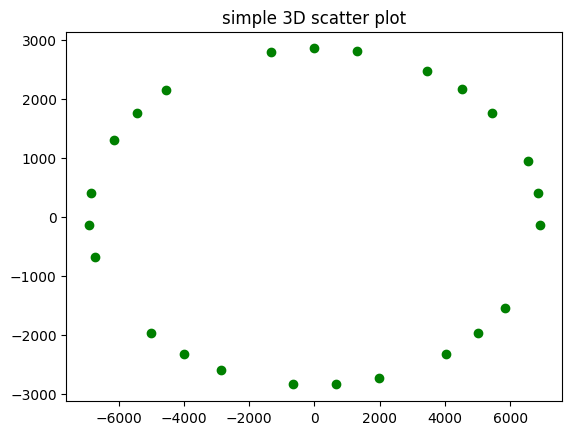

In [64]:

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111)

# Creating plot
ax.scatter(xs, ys, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [5]:
import wikipedia as wp
import lxml 
import pandas as pd

html = wp.page('2024_in_spaceflight').html().encode('UTF-8')

try: 
    df = pd.read_html(html)[3]  # Try 2nd table first as most pages contain contents table first
except IndexError:
    df = pd.read_html(html)[0]
print(df.to_string())

                                                                Date and time (UTC)                                                                          Rocket                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Flight number                                                                                                                                                                                                                                                                               

In [46]:
launches = []

[[{'id': 'f5a5ba75-16c4-4f30-9262-3195a2016f44',
   'url': 'https://ll.thespacedevs.com/2.2.0/launch/f5a5ba75-16c4-4f30-9262-3195a2016f44/',
   'slug': 'falcon-9-block-5-starlink-group-2-6-ion-scv009',
   'name': 'Falcon 9 Block 5 | Starlink Group 2-6 & ION SCV009',
   'status': {'id': 1,
    'name': 'Go for Launch',
    'abbrev': 'Go',
    'description': 'Current T-0 confirmed by official or reliable sources.'},
   'last_updated': '2023-01-30T17:10:59Z',
   'net': '2023-01-31T16:15:00Z',
   'window_end': '2023-01-31T16:15:00Z',
   'window_start': '2023-01-31T16:15:00Z',
   'probability': None,
   'holdreason': '',
   'failreason': '',
   'hashtag': None,
   'launch_service_provider': {'id': 121,
    'url': 'https://ll.thespacedevs.com/2.2.0/agencies/121/',
    'name': 'SpaceX',
    'type': 'Commercial'},
   'rocket': {'id': 7735,
    'configuration': {'id': 164,
     'url': 'https://ll.thespacedevs.com/2.2.0/config/launcher/164/',
     'name': 'Falcon 9',
     'family': 'Falcon',
    

In [38]:
import requests
import json

def getLaunches(numSat):
    url = "https://ll.thespacedevs.com/2.2.0/launch/upcoming/?limit=100&offset={numSat}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Save the response to an object
        launches.append(data['results'])
    else:
        print("Request failed with status code:", response.status_code, response.reason)

In [44]:
getLaunches(0)
print(len(launches))
getLaunches(100)
print(len(launches))
getLaunches(200)
print(len(launches))
getLaunches(300)
print(len(launches))


6
7
8
9


In [49]:
launches

[[{'id': 'f5a5ba75-16c4-4f30-9262-3195a2016f44',
   'url': 'https://ll.thespacedevs.com/2.2.0/launch/f5a5ba75-16c4-4f30-9262-3195a2016f44/',
   'slug': 'falcon-9-block-5-starlink-group-2-6-ion-scv009',
   'name': 'Falcon 9 Block 5 | Starlink Group 2-6 & ION SCV009',
   'status': {'id': 1,
    'name': 'Go for Launch',
    'abbrev': 'Go',
    'description': 'Current T-0 confirmed by official or reliable sources.'},
   'last_updated': '2023-01-30T17:10:59Z',
   'net': '2023-01-31T16:15:00Z',
   'window_end': '2023-01-31T16:15:00Z',
   'window_start': '2023-01-31T16:15:00Z',
   'probability': None,
   'holdreason': '',
   'failreason': '',
   'hashtag': None,
   'launch_service_provider': {'id': 121,
    'url': 'https://ll.thespacedevs.com/2.2.0/agencies/121/',
    'name': 'SpaceX',
    'type': 'Commercial'},
   'rocket': {'id': 7735,
    'configuration': {'id': 164,
     'url': 'https://ll.thespacedevs.com/2.2.0/config/launcher/164/',
     'name': 'Falcon 9',
     'family': 'Falcon',
    

In [50]:
for i in launches:
    print(f"{i[0]['slug']}\t{i[0]['id']}")

falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
falcon-9-block-5-starlink-group-2-6-ion-scv009	f5a5ba75-16c4-4f30-9262-3195a2016f44
